In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv
/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv
/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv
/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv
/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv


In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import pandas as pd

df1 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv")

df2 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv")

df3 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv")

df4 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv")

df5 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv")

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

df = df.drop(columns=['url'])

df.head()

,headlines,description,content,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,business


In [5]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len
        
        self.label_encoder = LabelEncoder().fit(y)
        #self.vocab = torchtext.vocab.GloVe(name='6B', dim=50)
        self.vocab = torchtext.vocab.Vectors("/kaggle/input/glove6b/glove.6B.50d.txt")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)
        
        text = self.X.iloc[idx]
        tokens = text.split()
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            
            tokens += ['<pad>'] * diff
        
        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        
        return X, label[0]
    
    
dataset = MyDataset(df['content'], df['category'])

100%|█████████▉| 400000/400001 [00:13<00:00, 29963.74it/s]


In [6]:
dataset[0][0].shape

torch.Size([100, 50])

In [7]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [8]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [9]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math

from torch import Tensor


# Код змінено для batch_first=True

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [10]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()
        
        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim*max_len, num_classes)

    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(encoding_dim=50, max_len=100, num_classes=5).to(device)
model

TextClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=5000, out_features=5, bias=True)
)

In [11]:
params_num = 0

for param in model.parameters():
    size = param.size()
    
    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

41919

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [13]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.000100), epochs=10, device=cpu

Epoch    1   11sec	loss:       0.91	val_loss:      0.393	accuracy_score:      0.707	val_accuracy_score:      0.899	
Epoch    2   11sec	loss:      0.259	val_loss:      0.204	accuracy_score:      0.923	val_accuracy_score:      0.939	
Epoch    3   11sec	loss:      0.184	val_loss:      0.174	accuracy_score:      0.944	val_accuracy_score:      0.947	
Epoch    4   11sec	loss:      0.157	val_loss:      0.164	accuracy_score:      0.954	val_accuracy_score:      0.952	
Epoch    5   11sec	loss:      0.136	val_loss:      0.156	accuracy_score:       0.96	val_accuracy_score:      0.951	
Epoch    6   11sec	loss:      0.118	val_loss:      0.149	accuracy_score:      0.967	val_accuracy_score:      0.952	
Epoch    7   11sec	loss:      0.102	val_loss:      0.148	accuracy_score:      0.972	val_accuracy_score:      0.953	
Epoch    8   11sec	loss:     0.0896	val_loss:      0.142	accuracy_score:      0.978	val_accuracy_score:

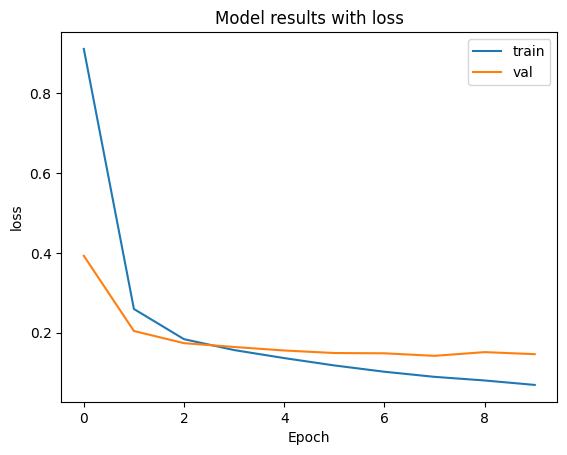

In [15]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

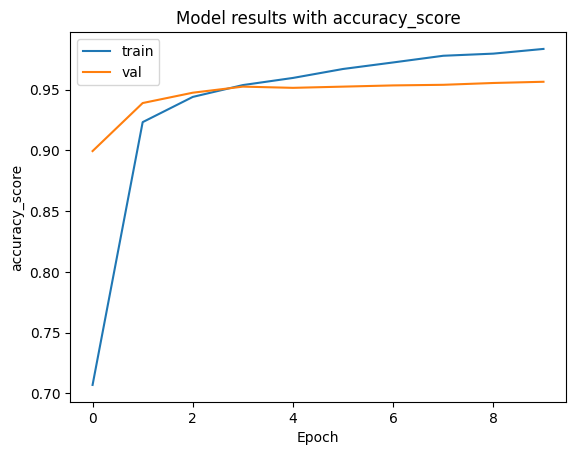

In [16]:
plot_metric(history, 'accuracy_score')

[]

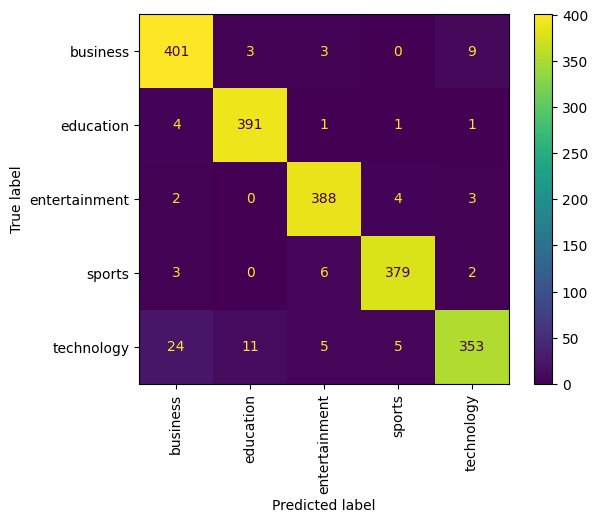

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

               precision    recall  f1-score   support

     business       0.92      0.96      0.94       416
    education       0.97      0.98      0.97       398
entertainment       0.96      0.98      0.97       397
       sports       0.97      0.97      0.97       390
   technology       0.96      0.89      0.92       398

     accuracy                           0.96      1999
    macro avg       0.96      0.96      0.96      1999
 weighted avg       0.96      0.96      0.96      1999

